## **Li-Ion Battery Parameters Estimation**

This project has the objective to analyze the charging/discharging process based on NASA Li-Ion datasets regarding the Stat of Health (SoH) degradation. In order to start this topic, we have to define a model and what parameters may vary. For that we start with the electrical model of a battery which is described as it follows:
$$ V = V_{OCV}(SoC(t)) + R_0i(t) + \sum_{k = 1}^{N} V_{c,i}(t) $$
Here is depicted the output voltage V, which is computed by adding the open-circuit voltage $V_{OCV}$, the internal voltage drop computed by $R_0i(t)$ and also the voltage drops across each RC filter structure ($V_{c,i}$). The problem that arises from this model definition is that the open-circuit voltage is highly non-linear with regards to the State of Charge ($SoC$). 

The tools used in this project are declared bellow.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Short description for every library used in this project:
1. The os library is used for file manipulation (path creation or directory iteration)
2. The pandas library is used to work the given data (read the csv files or save to a csv)
3. Numpy is used in order to better integrate numerical data in vectors or matrices.
4. Matplotlib is needed for data visualization
5. Statsmodel provides the tools necessary for data filtration
6. Scikit Learn gives the project all the needed tools to create Machine Learning models.

The following function is used in order to read the data that is given in a csv format and returns the state of charge and voltage extracted. It also makes sure that the data is reliable by taking only the part that represents viable data.

In [2]:
def process_data(file_path):
    data = pd.read_csv(file_path)
    last_index = np.argmin(data['Voltage_measured'])
    capacity = data['Capacity'][0]
    voltage = np.array(data['Voltage_measured'][0 : last_index + 1])
    current = np.array(data['Current_measured'][0 : last_index + 1])
    time = np.array(data['Time'][0 : last_index + 1])
    soc = 1 + current*time/capacity/3600
    soc[soc < 0] = 0

    return soc, voltage

The fit_polynomial function takes as inputs the **"input_data"** which represents the vector X in a machine learning context, the **"output_data"** which represents the taget y and the order for which we want the model to estimate. Also from tests, no bias should be used. The function returns the estimated output and also the parameters of the model.

In [3]:
def fit_polynomial(input_data, output_data, order):
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree = order, include_bias = True)
    input_features = poly_features.fit_transform(input_data.reshape(-1, 1))
    
    model.fit(input_features, output_data)
    voltage_predicted = model.predict(input_features)
    coefficients = np.concatenate(([model.intercept_], model.coef_[1:]))
    
    return voltage_predicted, coefficients

This is a function that can be used for visualization. To enable it, remove the comment in the next function.

In [4]:
def plot_comparison(soc, voltage, voltage_predicted):
    plt.scatter(soc, voltage, color = 'red', marker = 'x', s = 10)
    plt.plot(soc, voltage_predicted, color = 'blue')
    plt.xlabel("State of Charge (%)")
    plt.ylabel("Voltage (V)")
    plt.title("Voltage vs State of Charge")
    plt.show()
    plt.close()

The **analyze_discharge_data** function takes the order of which we want to identify the system, the folder path to the acctual folder that contains the csv files and the folder output which is the location where the Params.csv file should appear. In the resulted csv file should appear all the parameters estimated with the fit_polynomial function and their evolution.

In [5]:
def analyze_discharge_data(order, folder_path, folder_output):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
    csv_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    params = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file)

        soc, voltage = process_data(file_path)
        voltage_predicted, weights = fit_polynomial(soc, voltage, order)
        #plot_comparison(soc, voltage, voltage_predicted)
        params.append(weights)

    columns = [f"w{i+1}" for i in range(order+1)]
    data = pd.DataFrame(params, columns = columns)
    output_file_name = os.path.join(folder_output, "Params.csv")
    data.to_csv(output_file_name, index=False)
    print("Params successfully saved")

In [9]:
analyze_discharge_data(8, "datasets/battery_18/Discharge", "datasets/battery_18")

Params successfully saved


## **Parameters evolution**

This section is made to visualize the results obtained earlier. Here we can clearly see that the parameters follow a curved trend. To better see this corelation, test all the cases for all the battery presented in the dataset. We also see that this data is quite noisy, so for us to fit a new estimation of the parameters we need first of all to filter the data. Also keep in mind that here we can see the degradation for each parameter estimated before over discharge cycles. One more important observation is that by observing this trend we can decide if the battery is viable or not. So when a battery has parameters that break this trend consistently we can confidently say that the battery is close to it's demise.

In [10]:
def plot_weights(csv_file):
    data = pd.read_csv(csv_file)
    num_weights = len(data.columns)
    
    for i in range(num_weights):
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(data)), data.iloc[:, i], label=f"Weight {i + 1}", marker='o')
        plt.title(f"Weight {i + 1} Across Different Datasets")
        plt.xlabel("Discharging Cycles")
        plt.ylabel(f"Weight {i + 1}")
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.show()

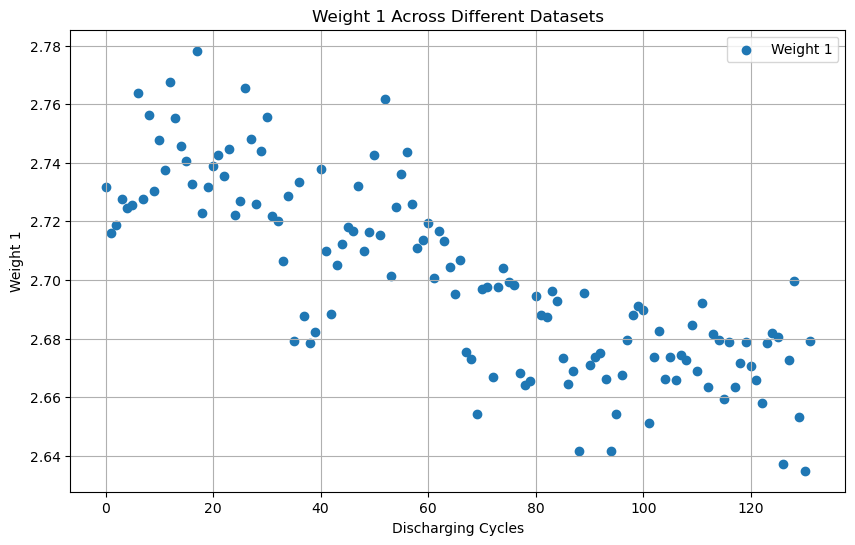

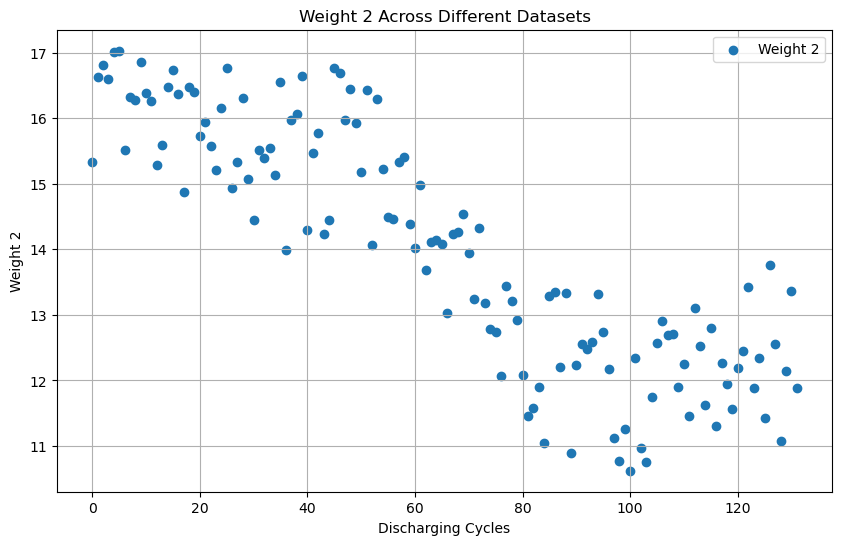

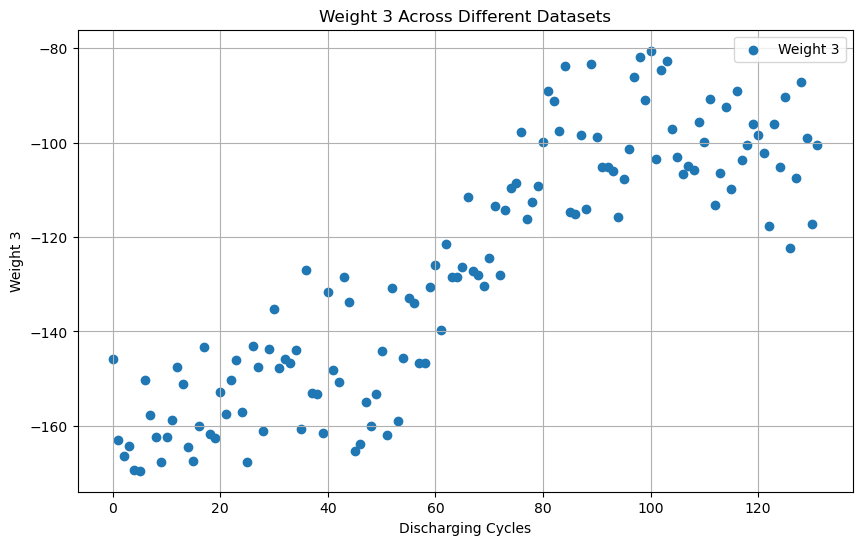

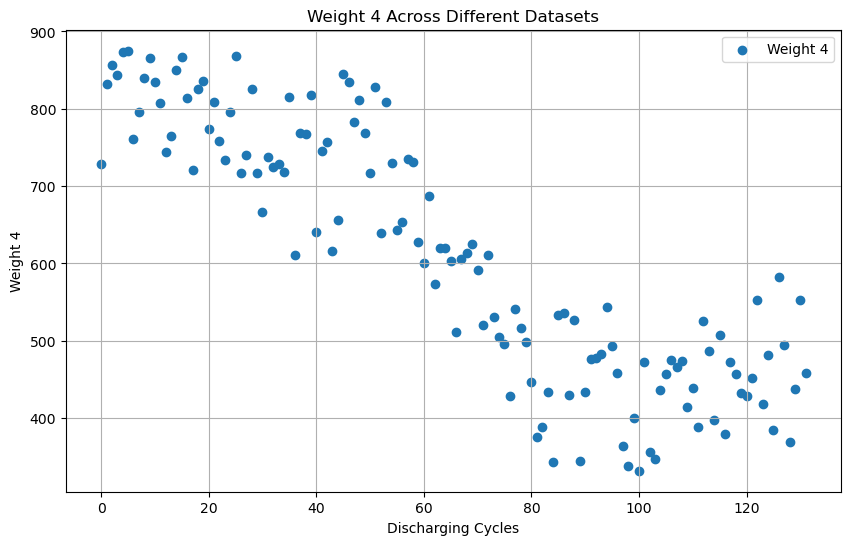

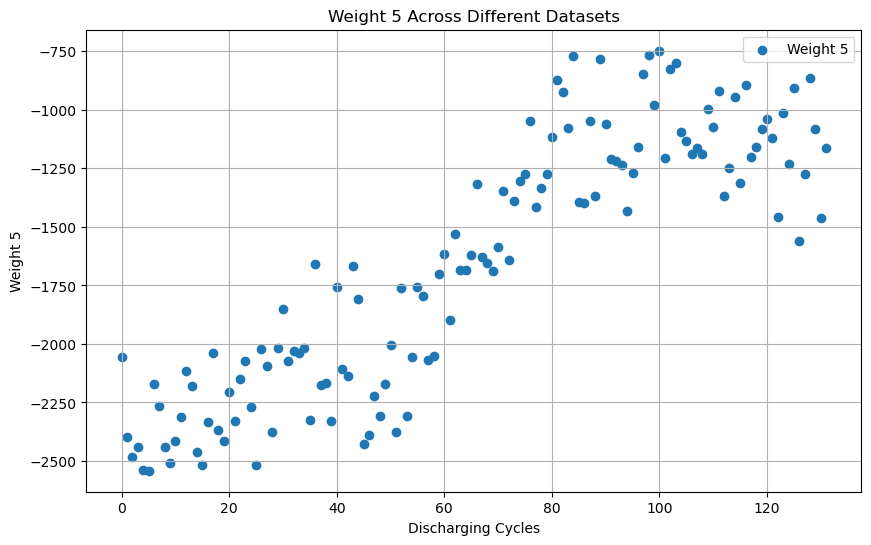

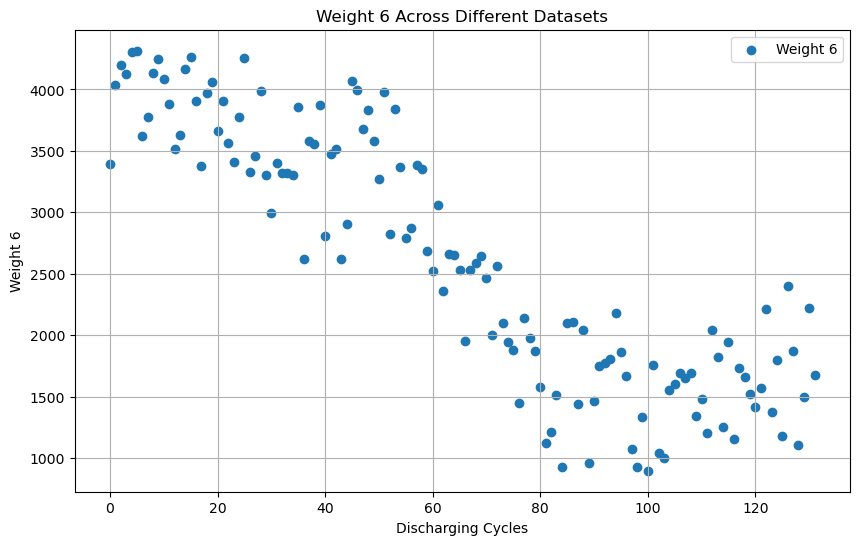

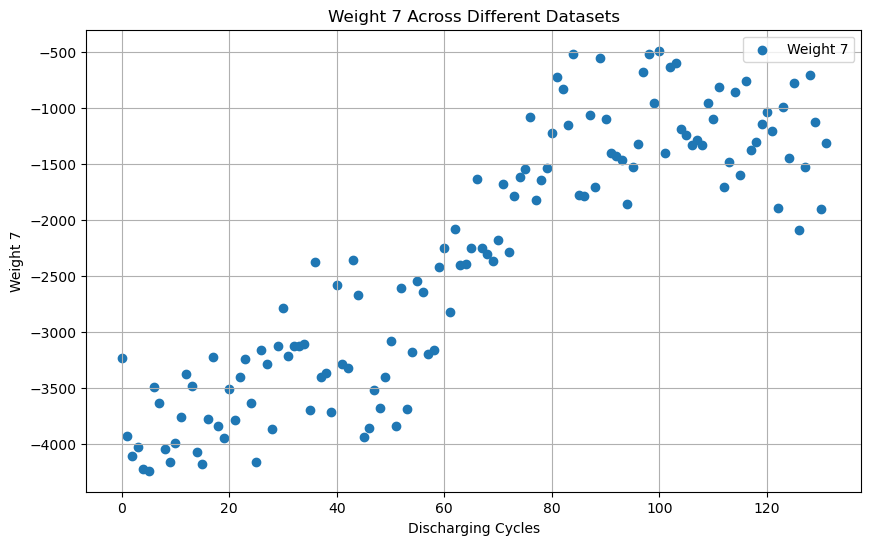

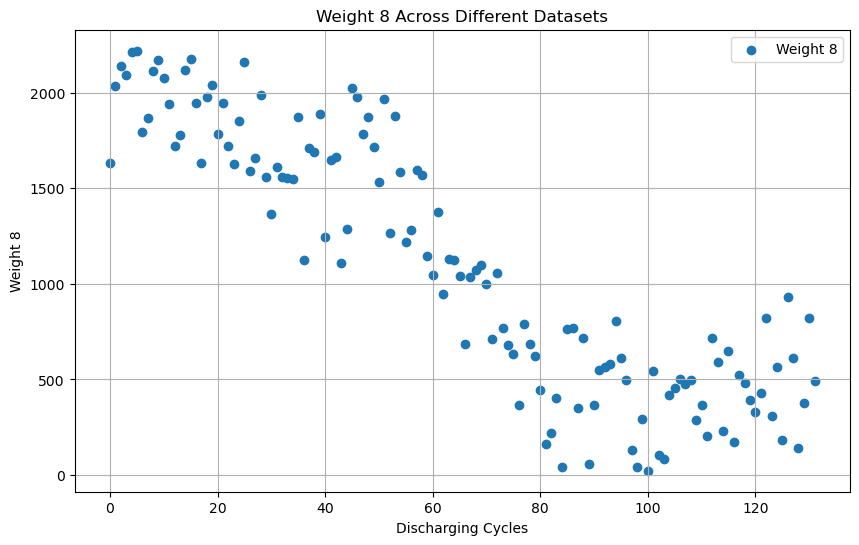

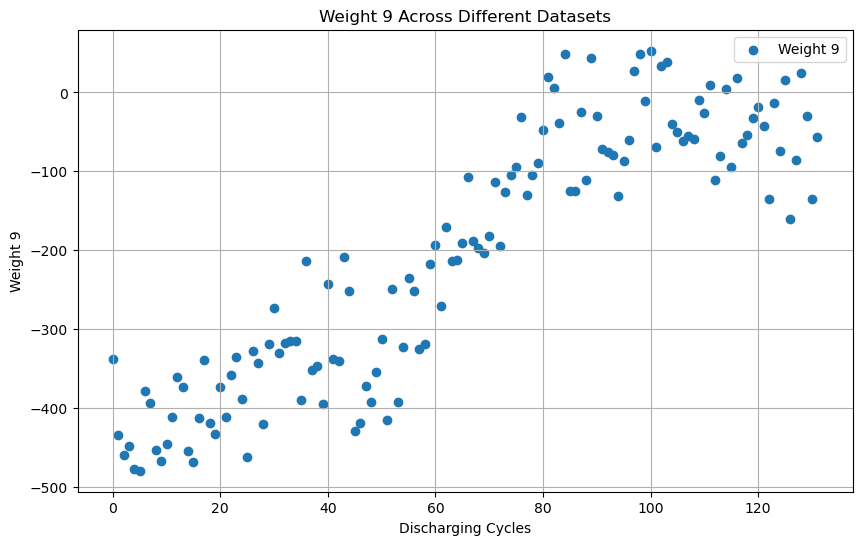

In [14]:
plot_weights("datasets/battery_18/Params.csv")

## **Parmeters degradation estimation**

In this section we want to predict the degradation of the parameters that are identified in the first chapter. As mentioned before, a data filtration is needed so the following function filter using the LOWESS method. 

In [15]:
def filter_training_data(x, y):
    filtered_data = sm.nonparametric.lowess(y, x, frac = 0.1)
    return filtered_data

Here we visualize the parameters degradation and also we try to fit a function that will be used as a deciding trend which when crossed consistently indicates the death of a battery but also it can be used to know the aproximative state of the battery which can be used in control applications.

In [16]:
def fit_polynomial_with_bias(input_data, output_data, order):
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree = order, include_bias = True)
    input_features = poly_features.fit_transform(input_data.reshape(-1, 1))
    
    model.fit(input_features, output_data)
    voltage_predicted = model.predict(input_features)
    coefficients = np.concatenate(([model.intercept_], model.coef_[1:]))
    
    return voltage_predicted, coefficients

def estimate_parameters_degradation(order, csv_file, folder_output):
    data = pd.read_csv(csv_file)
    num_weights = len(data.columns)
    degradation_params = []
    
    for i in range(num_weights):
        w_i = data.iloc[:, i]
        discharge_cycles = np.array(range(1,len(w_i)+1))
        
        #training_data = filter_training_data(discharge_cycles, viable_data)
        w_i_estimation, params = fit_polynomial_with_bias(discharge_cycles, w_i, order)

        degradation_params.append(params)
        
        plt.figure(figsize = (10,6))
        plt.scatter(discharge_cycles, w_i, marker = "x", color = "red")
        plt.plot(discharge_cycles, w_i_estimation, color = "blue")
        plt.show()

    columns = [f"a{i}" for i in range(order + 1)]
    data = pd.DataFrame(degradation_params, columns = columns)
    output_file_name = os.path.join(folder_output, "Degradation_dynamic.csv")
    data.to_csv(output_file_name, index=False) 

In [ ]:
estimate_parameters_degradation(3,"datasets/battery_18/Params.csv","datasets/battery_18")

## **Testing the results**

In [5]:
def test_results(folder_path, degradation_dynamic_path):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
    csv_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    a = np.array(pd.read_csv(degradation_dynamic_path))
    m, _ = a.shape
    discharge_cycle = 1

    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        soc, voltage = process_data(file_path)
        w = []
        estimations = []
        
        for i in range(m):
            w_i = np.polyval(a[i][::-1], discharge_cycle)
            w.append(w_i)
        
        for i in range(len(soc)):
            estimation = np.polyval(w[::-1], soc[i])
            estimations.append(estimation)
        
        plt.plot(soc, estimations)
        plt.scatter(soc, voltage, color = "red", marker = "x", s = 10)
        plt.show()

        discharge_cycle += 1

In [ ]:
test_results("datasets/battery_7/Discharge", "datasets/battery_7/Degradation_dynamic.csv")